# "1.4- NLP: Machine Translation and Document Search"
> "Procesamiento del lenguaje natural with Classification and Vector Spaces"

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [python, NLP, ML]
- image: images/framework.jpg
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2

Fuentes:
[DeepLearning.AI: Procesamiento de lenguaje natural. Programa especializado en Coursera](https://www.coursera.org/specializations/natural-language-processing) 

# Transforming word vectors
- From languaje X to languaje Y -> X R =Y
- Learn R:
- ![](images/nlp027.png)

![](images/nlp028.png)

# K-nearest neighbors
we need to find the most similar vectors to your output.

## Hashing
- **hash_function** = takes data of arbitrary sizes and maps it to a fixed value.
-  you don't have to compare it to all the other examples, you can just compare it to all the values in the same hash_bucket that input has been hashed to. 

![](images/nlp029.png)
![](images/nlp030.png)

In [10]:
def basic_hash_table(value_l, n_buckets):
    
    def hash_function(value, n_buckets):
        return int(value) % n_buckets
    
    hash_table = {i:[] for i in range(n_buckets)} # Initialize all the buckets in the hash table as empty lists

    for value in value_l:
        hash_value = hash_function(value,n_buckets) # Get the hash key for the given value
        hash_table[hash_value].append(value) # Add the element to the corresponding bucket
    
    return hash_table

In [9]:
value_l = [100, 10, 14, 17, 97] # Set of values to hash
hash_table_example = basic_hash_table(value_l, n_buckets=10)
pp.pprint(hash_table_example)

{   0: [100, 10],
    1: [],
    2: [],
    3: [],
    4: [14],
    5: [],
    6: [],
    7: [17, 97],
    8: [],
    9: []}


##  locality sensitive hashing
technique that allows you to hash similar inputs into the same buckets with high probability. 

![](images/nlp031.png)

## Multiple Planes
To get a single hash value.

![](images/nlp032.png)

In [73]:
import numpy as np   # library for array and matrix manipulation
import pandas as pd
import pprint                     # utilities for console printing 
import matplotlib.pyplot as plt   # visualization library
pp = pprint.PrettyPrinter(indent=4) # Instantiate a pretty printer
import pdb
import pickle
import string
import time
#import gensim
import nltk
import scipy
import sklearn
#from gensim.models import KeyedVectors
from nltk.corpus import stopwords, twitter_samples
from nltk.tokenize import TweetTokenizer
from os import getcwd

In [66]:
# add folder, tmp2, from our local workspace containing pre-downloaded corpora files to nltk's data path
filePath = f"{getcwd()}/tmp2/"
nltk.data.path.append(filePath)

In [71]:
def get_dict(file_name):
    """
    This function returns the english to french dictionary given a file where the each column corresponds to a word.
    Check out the files this function takes in your workspace.
    """
    my_file = pd.read_csv(file_name, delimiter=' ')
    etof = {}  # the english to french dictionary to be returned
    for i in range(len(my_file)):
        # indexing into the rows.
        en = my_file.loc[i][0]
        fr = my_file.loc[i][1]
        etof[en] = fr

    return etof

In [72]:
def cosine_similarity(A, B):
    '''
    Input:
        A: a numpy array which corresponds to a word vector
        B: A numpy array which corresponds to a word vector
    Output:
        cos: numerical number representing the cosine similarity between A and B.
    '''
    # you have to set this variable to the true label.
    cos = -10
    dot = np.dot(A, B)
    norma = np.linalg.norm(A)
    normb = np.linalg.norm(B)
    cos = dot / (norma * normb)

    return cos

In [64]:
def process_tweet(tweet):
    '''
    Input:
        tweet: a string containing a tweet
    Output:
        tweets_clean: a list of words containing the processed tweet

    '''
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and  # remove stopwords
            word not in string.punctuation):  # remove punctuation
            # tweets_clean.append(word)
            stem_word = stemmer.stem(word)  # stemming word
            tweets_clean.append(stem_word)

    return tweets_clean

In [65]:
# Procedure to plot and arrows that represents vectors with pyplot
def plot_vectors(vectors, colors=['k', 'b', 'r', 'm', 'c'], axes=None, fname='image.svg', ax=None):
    scale = 1
    scale_units = 'x'
    x_dir = []
    y_dir = []
    
    for i, vec in enumerate(vectors):
        x_dir.append(vec[0][0])
        y_dir.append(vec[0][1])
    
    if ax == None:
        fig, ax2 = plt.subplots()
    else:
        ax2 = ax
      
    if axes == None:
        x_axis = 2 + np.max(np.abs(x_dir))
        y_axis = 2 + np.max(np.abs(y_dir))
    else:
        x_axis = axes[0]
        y_axis = axes[1]
        
    ax2.axis([-x_axis, x_axis, -y_axis, y_axis])
        
    for i, vec in enumerate(vectors):
        ax2.arrow(0, 0, vec[0][0], vec[0][1], head_width=0.05 * x_axis, head_length=0.05 * y_axis, fc=colors[i], ec=colors[i])
    
    if ax == None:
        plt.show()
        fig.savefig(fname)


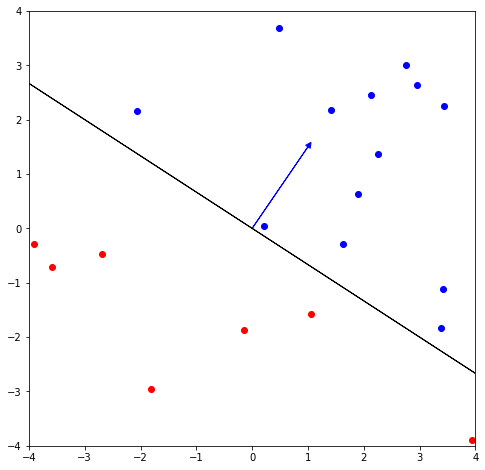

In [14]:
P = np.array([[1, 1.5]])  # Define a single plane. You may change the direction

# Get a new plane perpendicular to P. We use a rotation matrix
PT = np.dot([[0, 1], [-1, 0]], P.T).T  

fig, ax1 = plt.subplots(figsize=(8, 8)) # Create a plot with custom size

plot_vectors([P], colors=['b'], axes=[2, 2], ax=ax1) # Plot the plane P as a vector

# Plot the plane P as a 2 vectors. 
# We scale by 2 just to get the arrows outside the current box
plot_vectors([PT * 4, PT * -4], colors=['k', 'k'], axes=[4, 4], ax=ax1)

# Plot 20 random points. 
for i in range(0, 20):
        v1 = np.array(np.random.uniform(-4, 4, 2)) # Get a pair of random numbers between -4 and 4 
        side_of_plane = np.sign(np.dot(P, v1.T)) # Get the sign of the dot product with P
        # Color the points depending on the sign of the result of np.dot(P, point.T)
        if side_of_plane == 1:
            ax1.plot([v1[0]], [v1[1]], 'bo') # Plot a blue point
        else:
            ax1.plot([v1[0]], [v1[1]], 'ro') # Plot a red point

plt.show()

In [31]:
def side_of_plane_scalar(P, v):  # scalar
    dotproduct = np.dot(P, v.T) # Get the dot product P * v'
    sign_of_dot_product = np.sign(dotproduct) # The sign of the elements of the dotproduct matrix 
    sign_of_dot_product_scalar = sign_of_dot_product.item() # The value of the first item
    return sign_of_dot_product_scalar

In [32]:
def hash_multi_plane(P_l, v):
    hash_value = 0
    for i, P in enumerate(P_l):
        sign = side_of_plane_scalar(P,v)
        hash_i = 1 if sign >=0 else 0
        hash_value += 2**i * hash_i
    return hash_value

In [50]:
P1 = np.array([[1, 1]])   # First plane 2D
P2 = np.array([[-1, 1]])  # Second plane 2D
P3 = np.array([[-1, -1]]) # Third plane 2D
P_l = [P1, P2, P3]  # List of arrays. It is the multi plane

# Vector to search
v = np.array([[2,2]])

In [39]:
hash_multi_plane(P_l, v) # Find the number of the plane that containes this value

3

In [40]:
# Side of the plane function. The result is a matrix
def side_of_plane_matrix(P, v):
    dotproduct = np.dot(P, v.T)
    sign_of_dot_product = np.sign(dotproduct) # Get a boolean value telling if the value in the cell is positive or negative
    return sign_of_dot_product

## Random Planes

In [57]:
np.random.seed(1)
num_dimensions = 2 # is 300 in assignment
num_planes = 3 # is 10 in assignment
random_planes_matrix = np.random.normal(
                       size=(num_planes,
                             num_dimensions))
print(random_planes_matrix)

[[ 1.62434536 -0.61175641]
 [-0.52817175 -1.07296862]
 [ 0.86540763 -2.3015387 ]]


In [58]:
sides_l = side_of_plane_matrix(random_planes_matrix, v)
sides_l

array([[ 1.],
       [-1.],
       [-1.]])

# Approximate nearest neighbors
trades off accuracy for efficiency

# Naive Machine Translation and LSH

## The word embeddings data for English and French words

In [69]:
en_embeddings_subset = pickle.load(open("./data/en_embeddings.p", "rb"))
fr_embeddings_subset = pickle.load(open("./data/fr_embeddings.p", "rb"))

In [74]:
# loading the english to french dictionaries
en_fr_train = get_dict('./data/en-fr.train.txt')
print('The length of the English to French training dictionary is', len(en_fr_train))
en_fr_test = get_dict('./data/en-fr.test.txt')
print('The length of the English to French test dictionary is', len(en_fr_test))

The length of the English to French training dictionary is 5000
The length of the English to French test dictionary is 1500


### Generate embedding and transform matrices

In [76]:
def get_matrices(en_fr, french_vecs, english_vecs):
    """
    Input:
        en_fr: English to French dictionary
        french_vecs: French words to their corresponding word embeddings.
        english_vecs: English words to their corresponding word embeddings.
    Output: 
        X: a matrix where the columns are the English embeddings.
        Y: a matrix where the columns correspong to the French embeddings.
        R: the projection matrix that minimizes the F norm ||X R -Y||^2.
    """    
    # X_l and Y_l are lists of the english and french word embeddings
    X_l = list()
    Y_l = list()    
    # get the english words (the keys in the dictionary) and store in a set()
    english_set = set(english_vecs.keys())  
    # get the french words (keys in the dictionary) and store in a set()
    french_set = set(french_vecs.keys())    
    # store the french words that are part of the english-french dictionary (these are the values of the dictionary)
    french_words = set(en_fr.values())
    
    # loop through all english, french word pairs in the english french dictionary
    for en_word, fr_word in en_fr.items():
        # check that the french word has an embedding and that the english word has an embedding
        if fr_word in french_set and en_word in english_set:
            # get the english embedding
            en_vec = english_vecs[en_word]
            # get the french embedding
            fr_vec = french_vecs[fr_word]
            # add the english embedding to the list
            X_l.append(en_vec)
            # add the french embedding to the list
            Y_l.append(fr_vec)
    # stack the vectors of X_l into a matrix X
    X = np.array(X_l)
    # stack the vectors of Y_l into a matrix Y
    Y = np.array(Y_l) 
    
    return X, Y

In [81]:
# getting the training set:
X_train, Y_train = get_matrices(
    en_fr_train, fr_embeddings_subset, en_embeddings_subset)

## Translations